# 4. Procedural scene

## Overview

This tutorial give a brief overview on how to procedurally generate a mesh and use it in a scene fully constructed using `load_dict`. As in the previous tutorial, we will then render and display the scene in the notebook.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Procedurally generate a mesh</li>
  <li>Assemble a scene directly in Python</li>
  <li>Transform an existing mesh using the traverse mechanism</li>    
</ul>
    
</div>

### Step 1 - setup

For the sake of completeness, we are going to enable one of the GPU variant of the renderer in this toturial. Although please note that the following tutorial should work seemlessly with any other JIT variants (e.g. LLVM).

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
import enoki as ek 
import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

### Step 2 - procedural mesh generation

For the procedural mesh, we are going to generate a spanning triangle disk and give it a *wavy* fringe to make it look more interesting. The following code is a great example on how to use enoki JIT arrays and routines to write vectorized code that can run seamlessly and efficiently on the CPU or GPU.

#### The Wavy Disk Algorithm

The algorithm for generating this wavy disk is simple: let `N` define the total number of vertices, the first `N-1` vertices will compose the fringe of the disk, while the last vertex should be placed at the center. This can easily be achieved by first generatating an array of `theta` values, and use `ek.sincos` to compute the `x` and `y` components of all the vertices. We can then oscillate the vertices height based on the angle `theta` for a given `frequency` and `amplitude`. Using a masked assignment, we can effortlessly move the last vertex to the center of the disk.

Computing the correpsonding face indices is also pretty straightforward. The first vertex of every face point be the vertex at the center (`idx=N-1`) and the other two can be assigned sequentially (modulo `N-2`).

We use the `mitsuba.render.Mesh` class to allocate the appropriate vertex position and face index buffers. Using the `traverse` mechanism defined in the previous tutorial, we can assign the precomputed vertex positions and face indices to the corresponding parameters of the mesh object.

It is important to note the use of `ek.ravel` to flatten the 3D arrays into continuous arrays as this is the memory layout expected by `Mesh` in Mitsuba.

Lastly, we call the `update()` method to notify the mesh of the changes made to its internal buffers. For instance, this will trigger the recomputation of its bounding box and vertex normals.

In [3]:
from mitsuba.core import Float, UInt32, Point3f, Vector3u
from mitsuba.render import Mesh
from mitsuba.python.util import traverse

# Disk with a wavy fringe parameters
N = 100
frequency = 12.0
amplitude = 0.4

# Generate the vertex positions
theta = ek.linspace(Float, 0.0, ek.TwoPi, N)
x, y = ek.sincos(theta)
z = amplitude * ek.sin(theta * frequency)
vertex_pos = Point3f(x, y, z)

# Move the last vertex to the center
vertex_pos[ek.eq(ek.arange(UInt32, N), N-1)] = 0.0

# Generate the face indices
idx = ek.arange(UInt32, N - 1)
face_indices = Vector3u(N - 1, (idx + 1) % (N - 2), idx % (N - 2))

# Create an empty mesh (allocates buffers)
mesh = Mesh("wavydisk", N, N - 1)

# Populate the mesh with the precomputed arrays using the traverse mechanism
mesh_params = traverse(mesh)
mesh_params['vertex_positions'] = ek.ravel(vertex_pos)
mesh_params['faces'] = ek.ravel(face_indices)
mesh_params.update()

It is worth mentioning the possiblily to write the mesh to a *ply* file using the `mitsuba.render.Mesh.write_ply` method.

In [4]:
mesh.write_ply('my_mesh.ply')

2021-09-13 13:27:13 INFO main [Mesh] Writing mesh to "my_mesh.ply" ..

2021-09-13 13:27:13 INFO main [Mesh] "my_mesh.ply": wrote 99 faces, 100 vertices (2.33 KiB in 0ms)

### Step 3 - assemble the scene

In [Tutorial 2](...) we have seen how to use the `mitsuba.core.xml.load_dict` routine to instantiate a single Mitsuba object. Here we will show that it is possible to create entire scenes using this function. As described in the [documentation](...), nested dictionaries will be instanciated as children objects (e.g. useful to associate a BSDF to a Shape).

The following code will instanciate a scene containing the most essential elements:

- An integrator: `path`
- A light source: `constant`
- A sensor: `perspective`
- The mesh we generated above

Note the use of a `ScalarTransform4f` to specify the sensor transform. While this looks harmless, you are probably wondering about the meaning of the `Scalar` prefix in the type name `ScalarTransform4f`. This is an important concept in Mitsuba 2 so let's take a little detour here:

No matter which variant of the system is enabled, some parts of the Mitsuba 2 framework will always operate in a *scalar* fashion, using the un-vectorized CPU backend. For instance, this is the case for the `mitsuba.core.Bitmap` class and the Mitsuba parser. E.g. it wouldn't make much sense to define a whole vectorized array of transforms just to describe the transformation of a single object. For this reason, most of the Mitsuba primitive types are exposed in two flavours:

- `<type>`: type variant corresponding to the enabled backend (e.g. `Float, Vector3f, Transform4f`, ...)
- `Scalar<type>`: scalar variant type, agnostic to the enabled backend (e.g. `ScalarFloat, ScalarVector3f, ScalarTransform4f`, ...)

The main takeaway here is to consistently use `Scalar<type>` type when specifying parameters in `load_dict`.

In [5]:
from mitsuba.core.xml import load_dict
from mitsuba.core import ScalarTransform4f

scene = load_dict({
    'type' : 'scene',
    'integrator' : { 
        'type' : 'path' 
    },
    'light' : { 
        'type' : 'constant' 
    },
    'sensor' : {
        'type' : 'perspective',
        'to_world' : ScalarTransform4f.look_at(origin=[0, -5, 5], 
                                               target=[0, 0, 0], 
                                               up=[0, 0, 1]),
    },
    'wavydisk' : mesh,
})

2021-09-13 13:27:13 INFO main [Scene] Building scene in OptiX ..

2021-09-13 13:27:13 INFO main [Scene] OptiX ready. (took 28ms)

Using the `mitsuba.python.util.render` and `matplotlib`, we can now easily render our scene and admire our beautiful wavy disk.

2021-09-13 13:27:13 INFO main [SamplingIntegrator] Start rendering...

2021-09-13 13:27:13 INFO main [SamplingIntegrator] Computation graph recorded. (took 3ms)

2021-09-13 13:27:14 INFO main [SamplingIntegrator] Code generation finished. (took 379ms)

2021-09-13 13:27:14 INFO main [SamplingIntegrator] Rendering finished. (took 390ms)

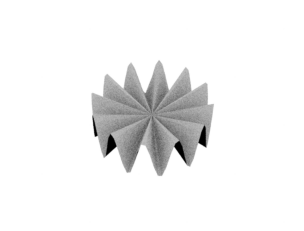

In [6]:
def render_and_show(scene):
    from mitsuba.core import Bitmap, Struct
    from matplotlib import pyplot as plt
    bitmap = scene.render()
    bitmap = bitmap.convert(Bitmap.PixelFormat.RGB, Struct.Type.UInt8, srgb_gamma=True)
    plt.imshow(bitmap); plt.axis('off');
    
render_and_show(scene)

### Step 4 - modify the mesh and update the scene

Let's assume we are now interested on applying a transformation to the wavy disk and render the scene again. As you have probably guessed it, this can be achieved using the `traverse` mechanism. Unfortunately, the relation between the mesh and the scene was not encoded in the `mesh_params` object, and it is therefore necessary to perfom a new traversal on the whole scene.

In `load_dict`, the keys in the passed dictionary define the IDs of the various object. Therefore the key corresponding to our wavy disk mesh will be `wavydisk.<parameter_name>`.

The `Transform4f` class provides several functions to create common transformations, such as `translate`, `scale`, `rotate`, `look_at`. In this example, we are going to use `Transform4f.rotate` to rotate our wavy disk around the y-axis by 30 degrees.

As stated above, the vertex position buffer of `Mesh` has a flat continuous layout. It is therefore required to convert it to a 3D array before applying the transformation. For this we use the `ek.unravel` function, providing the target array type as first argument, here `Vector3f`.

The transformation is applied using the `@` operator and we set the new positions to the vertex position buffer after using `ek.ravel` to flatten the array.

Finally, we notify the scene graph to propagate the update to the mesh buffers, which will trigger the recomputation of the scene's BVH.

In [7]:
from mitsuba.core import Transform4f

params = traverse(scene)
vertex_pos = ek.unravel(Point3f, params['wavydisk.vertex_positions'])
trans = Transform4f.rotate(axis=[0, 1, 0], angle=30)
new_vertex_pos = trans @ vertex_pos
params['wavydisk.vertex_positions'] = ek.ravel(new_vertex_pos)
params.update()

Finally let's render and display the updated scene.

2021-09-13 13:27:14 INFO main [SamplingIntegrator] Start rendering...

2021-09-13 13:27:14 INFO main [SamplingIntegrator] Computation graph recorded. (took 3ms)

2021-09-13 13:27:14 INFO main [SamplingIntegrator] Code generation finished. (took 372ms)

2021-09-13 13:27:14 INFO main [SamplingIntegrator] Rendering finished. (took 383ms)

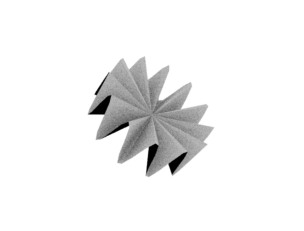

In [8]:
render_and_show(scene)

### *Reference API*

- [<code>mitsuba.core.xml.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.xml.load_file)
- [<code>mitsuba.core.Transform4f</code>](...)
- [<code>mitsuba.render.Mesh</code>](...)
- [<code>mitsuba.render.Mesh.write_ply</code>](...)
- [<code>mitsuba.python.util.traverse</code>](...)
- [<code>mitsuba.python.util.render</code>](...)
- [<code>mitsuba.python.util.SceneParameters</code>](...)
- [<code>mitsuba.python.util.SceneParameters.update</code>](...)